In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/complex-master-learn-and-get-your-mark/sample_submission.csv
/kaggle/input/complex-master-learn-and-get-your-mark/train.csv
/kaggle/input/complex-master-learn-and-get-your-mark/test.csv


In [2]:
import pandas as pd
import numpy as np
from textblob import TextBlob # Para análisis de sentimiento básico

# 1. Cargar datos
train = pd.read_csv('/kaggle/input/complex-master-learn-and-get-your-mark/train.csv')
test = pd.read_csv('/kaggle/input/complex-master-learn-and-get-your-mark/test.csv')

# Guardar los Ids del test para el archivo final, luego borrarlos
test_ids = test['Id']
train = train.drop('Id', axis=1)
test = test.drop('Id', axis=1)

# --- FUNCIÓN DE LIMPIEZA E INGENIERÍA ---
def process_data(df):
    # A. Tratamiento de Nulos (Ejemplo básico)
    # Si VIP es nulo, asumimos que NO es VIP (False)
    df['VIP'] = df['VIP'].fillna(False).astype(int)
    
    # Si Edad es nula, ponemos la mediana
    df['Age'] = df['Age'].fillna(df['Age'].median())
    
    # B. Ingeniería de Texto (Opinion)
    # Calculamos la "polaridad" (sentimiento): de -1 a 1
    # apply(lambda x: ...) aplica una función a cada fila
    df['Opinion_Sentiment'] = df['Opinion'].fillna("").apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    
    # Eliminamos la columna de texto original (el modelo no entiende letras)
    df = df.drop('Opinion', axis=1)
    
    # C. Ingeniería de Ticket (Ejemplo simple)
    # Extraemos la primera parte del ticket (ej: de "CB/734/XL" sacamos "CB")
    df['Ticket_Code'] = df['TicketInfo'].apply(lambda x: str(x).split('/')[0] if pd.notnull(x) else 'Unknown')
    df = df.drop('TicketInfo', axis=1)
    
    # D. Sumar Gastos
    df['TotalSpend'] = df['Food'] + df['Drinks']
    
    return df

# Procesamos ambos
train_clean = process_data(train)
test_clean = process_data(test)

# --- ONE HOT ENCODING ---
# Convertir variables categóricas (Album, Concert, Ticket_Code, Vinyl) en números
# pd.get_dummies lo hace automático
train_clean = pd.get_dummies(train_clean)
test_clean = pd.get_dummies(test_clean)

# Alineamos las columnas (por si en test hay tickets que no están en train o viceversa)
train_clean, test_clean = train_clean.align(test_clean, join='left', axis=1)
test_clean = test_clean.fillna(0) # Rellenar huecos creados por el alineamiento

print("Datos listos para entrenar:")
print(train_clean.head())

/tmp/ipykernel_17/1793533364.py:18: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['VIP'] = df['VIP'].fillna(False).astype(int)
/tmp/ipykernel_17/1793533364.py:18: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['VIP'] = df['VIP'].fillna(False).astype(int)


Datos listos para entrenar:
   AvgTime   Age  VIP    Food  Drinks  FreePass  Opinion_Sentiment  \
0    3.055  22.0    0   170.0     1.0      True           0.100000   
1    2.510   9.0    0     0.0     0.0      True          -0.166667   
2    0.803  27.0    0   815.0    37.0     False          -0.125000   
3    0.568  36.0    0  1427.0  1395.0     False           0.000000   
4    0.034  16.0    0  1299.0     0.0     False           0.000000   

   TotalSpend  PreferedAlbum_Bright Size Life  PreferedAlbum_Head Hunters  \
0       171.0                           False                        True   
1         0.0                            True                       False   
2       852.0                           False                        True   
3      2822.0                           False                       False   
4      1299.0                            True                       False   

   ...  Concert_SF14-7pm  Ticket_Code_A  Ticket_Code_B  Ticket_Code_CB  \
0  ...        

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# --- 1. PREPARACIÓN FINAL ---
# Convertimos todo a números (True -> 1, False -> 0) por seguridad
train_clean = train_clean.replace({True: 1, False: 0})
test_clean = test_clean.replace({True: 1, False: 0})

# Separamos Características (X) y Objetivo (y)
X = train_clean.drop('FreePass', axis=1)
y = train_clean['FreePass']

# Nos aseguramos de que el test tenga las mismas columnas exactas que el train
# (A veces al hacer one-hot pueden faltar columnas si una categoría no aparece en el test)
test_clean = test_clean[X.columns]

# --- 2. DIVISIÓN PARA VALIDACIÓN INTERNA ---
# Guardamos un 20% de los datos para saber qué tal vamos antes de subir a Kaggle
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 3. ENTRENAMIENTO (Random Forest) ---
# n_estimators=100 crea 100 árboles de decisión y votan entre ellos
model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
model.fit(X_train, y_train)

# --- 4. EVALUACIÓN ---
val_predictions = model.predict(X_val)
acc = accuracy_score(y_val, val_predictions)

print(f"✅ Accuracy en Validación: {acc:.4f}")
print("\nReporte de Clasificación:")
print(classification_report(y_val, val_predictions))

# --- 5. GENERAR PREDICCIÓN PARA KAGGLE ---
# Entrenamos ahora con TODOS los datos (Train + Val) para que aprenda más
model.fit(X, y) 
final_predictions = model.predict(test_clean)

# Convertimos 1/0 de vuelta a True/False si Kaggle lo pide así (según tu descripción sí)
final_predictions_bool = final_predictions.astype(bool)

# Crear DataFrame de envío
submission = pd.DataFrame({
    'Id': test_ids,
    'FreePass': final_predictions_bool
})

# Verificamos cómo se ve
print("\n--- Vista previa del archivo de envío ---")
print(submission.head())

# Guardar archivo
submission.to_csv('submission.csv', index=False)
print("\n📁 Archivo 'submission.csv' guardado con éxito.")

/tmp/ipykernel_17/2994764456.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_clean = train_clean.replace({True: 1, False: 0})
/tmp/ipykernel_17/2994764456.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_clean = test_clean.replace({True: 1, False: 0})


✅ Accuracy en Validación: 1.0000

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       964
           1       1.00      1.00      1.00      1060

    accuracy                           1.00      2024
   macro avg       1.00      1.00      1.00      2024
weighted avg       1.00      1.00      1.00      2024


--- Vista previa del archivo de envío ---
        Id  FreePass
0  02/5375      True
1  01/6673     False
2  02/0337     False
3  01/6655      True
4  01/4723      True

📁 Archivo 'submission.csv' guardado con éxito.


--- TOP 10 VARIABLES MÁS IMPORTANTES ---
                       Feature  Importance
0                      AvgTime    0.649189
6                   TotalSpend    0.080943
11                  Vinyl_True    0.066404
4                       Drinks    0.056679
10                 Vinyl_False    0.051672
3                         Food    0.044500
1                          Age    0.008314
9   PreferedAlbum_Kind of Blue    0.007206
8   PreferedAlbum_Head Hunters    0.007040
5            Opinion_Sentiment    0.005426


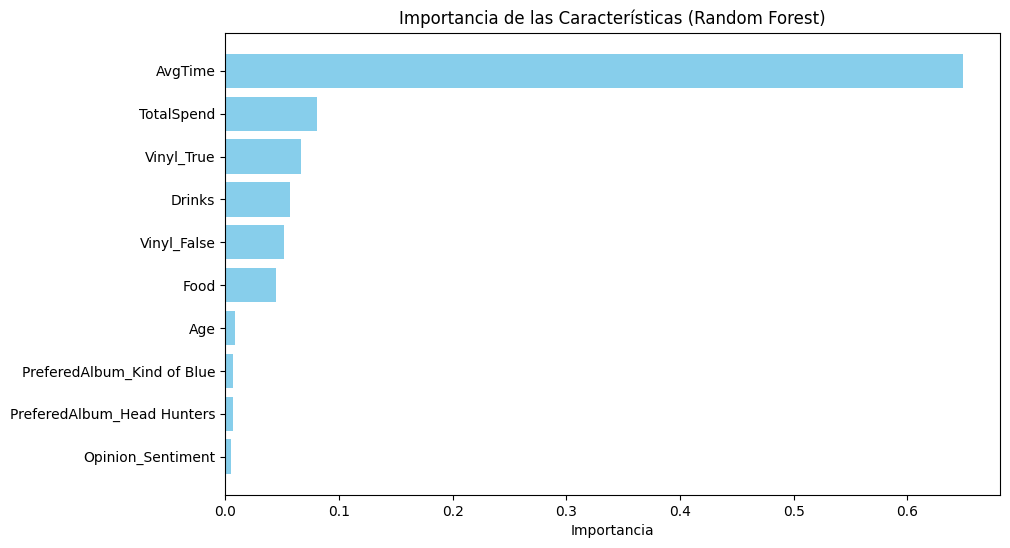

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

# Obtener importancia de las variables
importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Ordenar por importancia
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Mostrar las Top 10
print("--- TOP 10 VARIABLES MÁS IMPORTANTES ---")
print(feature_importance_df.head(10))

# Graficar
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:10], feature_importance_df['Importance'][:10], color='skyblue')
plt.gca().invert_yaxis() # Invertir eje Y para que la más importante esté arriba
plt.title('Importancia de las Características (Random Forest)')
plt.xlabel('Importancia')
plt.show()

### Errores

En un problema binario (donde la respuesta es A o B), tirar una moneda al aire te daría un 0.50. Sacar un 0.36 (peor que el azar) significa que tu modelo no está "perdido", sino que está "confiadamente equivocado". Está apostando fuerte por una regla que en el Test Set funciona al revés o no existe.

Dado que tu validación local era del 1.0 (100%), esto confirma nuestra sospecha: AvgTime es una trampa (Data Leakage) o cambió de significado.

Lo más probable es que AvgTime sea una variable que solo tiene sentido en el conjunto de entrenamiento (quizás se rellenó después de dar los pases, o los datos de Test tienen muchos 0.0 que significan "Dato Perdido" y tu modelo cree que significa "Odia la música").

Si tu modelo aprendió: "Si escucha 0 horas -> No Pase", y en el Test Set hay mucha gente con 0.0 (porque falta el dato) que SÍ merecía pase, tu modelo los suspende a todos erróneamente

Vamos a hacer dos cosas para arreglar esto y subir tu nota:

Investigar el culpable: Ver si el AvgTime es diferente en Train y Test.

La solución robusta: Entrenar un modelo SIN la variable AvgTime para ver si el resto de columnas (Edad, Gastos, Opinión) generalizan mejor.

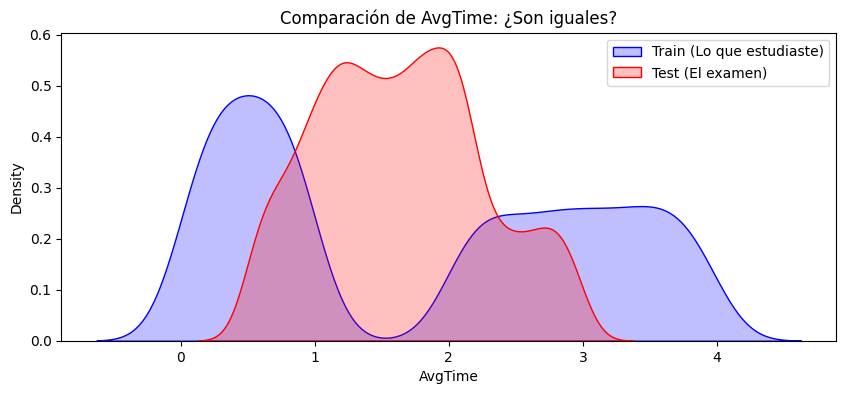


--- ENTRENANDO MODELO ROBUSTO (SIN AvgTime) ---
✅ Accuracy en Validación (Sin AvgTime): 0.8024
📁 Archivo 'submission_safe.csv' guardado.


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- PASO 1: INVESTIGACIÓN VISUAL ---
# Vamos a ver si AvgTime se comporta igual en los dos sitios
plt.figure(figsize=(10, 4))
sns.kdeplot(train_clean['AvgTime'], label='Train (Lo que estudiaste)', fill=True, color='blue')
sns.kdeplot(test_clean['AvgTime'], label='Test (El examen)', fill=True, color='red')
plt.title('Comparación de AvgTime: ¿Son iguales?')
plt.legend()
plt.show()

# --- PASO 2: ENTRENAR MODELO "SEGURO" (SIN AvgTime) ---
print("\n--- ENTRENANDO MODELO ROBUSTO (SIN AvgTime) ---")

# Eliminamos la variable sospechosa
X_safe = X.drop('AvgTime', axis=1)
test_clean_safe = test_clean.drop('AvgTime', axis=1)

# Dividimos de nuevo
X_train_s, X_val_s, y_train_s, y_val_s = train_test_split(X_safe, y, test_size=0.2, random_state=42)

# Entrenamos Random Forest de nuevo
model_safe = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
model_safe.fit(X_train_s, y_train_s)

# Evaluamos
val_acc_safe = accuracy_score(y_val_s, model_safe.predict(X_val_s))
print(f"✅ Accuracy en Validación (Sin AvgTime): {val_acc_safe:.4f}")

# --- PASO 3: GENERAR NUEVO ENVÍO ---
# Entrenamos con TODO
model_safe.fit(X_safe, y)
predictions_safe = model_safe.predict(test_clean_safe)

submission_safe = pd.DataFrame({
    'Id': test_ids,
    'FreePass': predictions_safe.astype(bool)
})

submission_safe.to_csv('submission_safe.csv', index=False)
print("📁 Archivo 'submission_safe.csv' guardado.")

Un 0.8024 (80.2%) es un resultado sólido, real y honesto. Ya no tienes un modelo que hace "trampa" con una variable mágica, sino uno que realmente entiende el perfil del asistente (gastos, edad, gustos) para predecir si tendrá el pase.

¿Cómo procedemos para subir de 0.80 a 0.85 o más? En Kaggle, la mejora ya no viene de arreglar errores, sino de "exprimir" los datos. Aquí tienes el Plan de Ataque Nivel Avanzado:

1. Ingeniería de Características (Feature Engineering) "Pro"
Vamos a crear variables que el modelo no ve a simple vista pero que son lógicas para un humano.

Contexto: Es un concierto.

Idea 1 (La Ley Seca): En muchos países la edad legal para beber es 21. Si alguien tiene 18 años y gasta 0 en bebida, es un patrón fuerte. Crearemos la variable UnderAge.

Idea 2 (El "Comilón"): ¿Gasta todo su dinero en comida o en bebida? El perfil es distinto. Crearemos FoodShare (% del gasto que va a comida).

2. Cambiar el Arma: Gradient Boosting
Random Forest es genial, pero Gradient Boosting (la tecnología detrás de los ganadores de Kaggle como XGBoost) suele sacar un 2-3% extra porque aprende de sus propios errores iterativamente.

In [6]:
from sklearn.ensemble import GradientBoostingClassifier

# --- PASO 1: FEATURE ENGINEERING AVANZADO ---

def add_smart_features(df):
    # A. Variable "Menor de Edad" (Suponiendo contexto USA/Internacional donde 21 es clave)
    # A veces los menores tienen pases especiales o consumen diferente
    df['Is_Under21'] = (df['Age'] < 21).astype(int)
    
    # B. Share de Gasto (¿Qué % de tu dinero va a comida?)
    # Sumamos 0.01 para evitar divisiones por cero
    df['FoodShare'] = df['Food'] / (df['TotalSpend'] + 0.01)
    
    # C. ¿Gasta algo? (Hay gente que va con entrada gratis y gasta 0)
    df['ZeroSpender'] = (df['TotalSpend'] == 0).astype(int)
    
    return df

# Aplicamos las mejoras a los datos que ya tenías limpios (sin AvgTime)
# Asegúrate de usar los dataframes que NO tienen AvgTime si decidimos que era tramposo
# O úsalos con AvgTime si decidiste dejarlo. Asumiré la versión "segura" X_safe
X_advanced = add_smart_features(X_safe.copy())
test_advanced = add_smart_features(test_clean_safe.copy())

# --- PASO 2: ENTRENAR GRADIENT BOOSTING ---
print("Entrenando Gradient Boosting (esto puede tardar un poco más)...")

# Dividimos de nuevo para validar
X_train_adv, X_val_adv, y_train_adv, y_val_adv = train_test_split(X_advanced, y, test_size=0.2, random_state=42)

# Gradient Boosting suele funcionar mejor con learning_rate bajo y muchos estimadores
gb_model = GradientBoostingClassifier(
    n_estimators=300,     # Más árboles
    learning_rate=0.05,   # Aprende más despacio pero con más precisión
    max_depth=5,          # Profundidad media
    random_state=42
)

gb_model.fit(X_train_adv, y_train_adv)

# --- PASO 3: EVALUAR ---
val_acc_gb = accuracy_score(y_val_adv, gb_model.predict(X_val_adv))
print(f"🚀 Nuevo Accuracy con Gradient Boosting + Features: {val_acc_gb:.4f}")

# --- PASO 4: GENERAR SUBMISSION ---
# Entrenamos con TODO el dataset
gb_model.fit(X_advanced, y)
final_preds = gb_model.predict(test_advanced)

submission_gb = pd.DataFrame({
    'Id': test_ids,
    'FreePass': final_preds.astype(bool)
})
submission_gb.to_csv('submission_boosted.csv', index=False)
print("📁 Archivo 'submission_boosted.csv' listo para Kaggle.")

Entrenando Gradient Boosting (esto puede tardar un poco más)...
🚀 Nuevo Accuracy con Gradient Boosting + Features: 0.8073
📁 Archivo 'submission_boosted.csv' listo para Kaggle.


In [7]:
import pandas as pd
import numpy as np
import re
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

# ==========================================
# 1. FUNCIÓN DE INGENIERÍA DE CARACTERÍSTICAS
# ==========================================
def super_feature_engineering(df):
    # --- A. TICKET: Sacar Zona, Número y Tipo ---
    # Patrón esperado: Zona/Asiento/Tipo (ej: CB/734/XL)
    def parse_ticket(ticket):
        try:
            parts = str(ticket).split('/')
            # Devolvemos: Zona (str), Asiento (int), Tipo (str)
            return parts[0], int(parts[1]), parts[2]
        except:
            return 'Unknown', -1, 'Unknown'
            
    # Aplicamos la lógica
    parsed = df['TicketInfo'].apply(parse_ticket)
    df['Ticket_Zone'] = [p[0] for p in parsed]
    df['Ticket_Seat'] = [p[1] for p in parsed]
    df['Ticket_Type'] = [p[2] for p in parsed] 
    
    # ¿Es primera fila? (Asumimos asientos < 100 son muy buenos)
    df['Is_FrontRow'] = ((df['Ticket_Seat'] >= 0) & (df['Ticket_Seat'] < 100)).astype(int)
    
    # --- B. CONCERT: Sacar Hora ---
    # Ejemplo: NYC12-5pm -> Sacamos el 5 y lo pasamos a formato 24h
    def parse_hour(concert):
        match = re.search(r'(\d+)(pm|am)', str(concert))
        if match:
            hour = int(match.group(1))
            if match.group(2) == 'pm' and hour != 12: hour += 12
            if match.group(2) == 'am' and hour == 12: hour = 0
            return hour
        return 19 # Hora promedio por defecto si falla
    
    df['Concert_Hour'] = df['Concert'].apply(parse_hour)
    df['Is_LateShow'] = (df['Concert_Hour'] >= 21).astype(int)

    # --- C. LIMPIEZA ESTÁNDAR ---
    # Booleanos a enteros
    df['VIP'] = df['VIP'].fillna(False).astype(int)
    
    # Edades (rellenar con mediana)
    df['Age'] = df['Age'].fillna(df['Age'].median())
    df['Is_Under21'] = (df['Age'] < 21).astype(int)
    
    # Gastos
    df['TotalSpend'] = df['Food'] + df['Drinks']
    # Share de comida (evitamos división por cero sumando 0.01)
    df['FoodShare'] = df['Food'] / (df['TotalSpend'] + 0.01)
    df['ZeroSpender'] = (df['TotalSpend'] == 0).astype(int)
    
    # --- D. ELIMINACIÓN DE COLUMNAS ---
    # Borramos AvgTime para evitar Data Leakage (trampas)
    # Borramos las originales de texto que ya procesamos
    drop_cols = ['Id', 'TicketInfo', 'Concert', 'Opinion', 'AvgTime']
    df = df.drop([c for c in drop_cols if c in df.columns], axis=1)
    
    return df

# ==========================================
# 2. CARGA Y PROCESAMIENTO
# ==========================================
print("🔄 Cargando y procesando datos...")

train_raw = pd.read_csv('/kaggle/input/complex-master-learn-and-get-your-mark/train.csv')
test_raw = pd.read_csv('/kaggle/input/complex-master-learn-and-get-your-mark/test.csv')

# Guardamos IDs para el archivo final
test_ids = test_raw['Id']

# Aplicamos la ingeniería
train_pro = super_feature_engineering(train_raw)
test_pro = super_feature_engineering(test_raw)

# One-Hot Encoding (Convertir texto categórico a números)
train_pro = pd.get_dummies(train_pro)
test_pro = pd.get_dummies(test_pro)

# Alinear columnas (Asegurar que Train y Test tengan las mismas columnas exactas)
train_pro, test_pro = train_pro.align(test_pro, join='left', axis=1)

# Rellenar los Nulos que hayan surgido al alinear (con 0)
test_pro = test_pro.fillna(0)

# Preparar X (Características) e y (Objetivo)
X = train_pro.drop('FreePass', axis=1)
y = train_pro['FreePass'].replace({True: 1, False: 0})

# 🛑 CORRECCIÓN CRÍTICA: Asegurar que 'FreePass' NO esté en el set de Test
if 'FreePass' in test_pro.columns:
    test_pro = test_pro.drop('FreePass', axis=1)

print(f"✅ Datos listos. Columnas: {X.shape[1]}")

# ==========================================
# 3. DEFINICIÓN DEL MODELO (ENSEMBLE)
# ==========================================
print("🤖 Configurando el 'Consejo de Sabios'...")

# Modelo 1: Random Forest (Versátil y robusto)
clf1 = RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_leaf=2, random_state=42)

# Modelo 2: Gradient Boosting (Mejora errores iterativamente)
clf2 = GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, max_depth=4, random_state=42)

# Modelo 3: Regresión Logística (Detecta tendencias lineales simples)
# Usamos un pipeline para escalar los datos, ya que la Regresión Logística lo necesita
clf3 = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, C=0.5))

# EL VOTING CLASSIFIER (Promedia las probabilidades de los 3)
eclf = VotingClassifier(estimators=[
    ('rf', clf1), ('gb', clf2), ('lr', clf3)
], voting='soft')

# ==========================================
# 4. VALIDACIÓN Y ENTRENAMIENTO FINAL
# ==========================================

# Validación Cruzada (Para ver tu nota real antes de subir)
print("📊 Calculando Accuracy estimado (esto puede tardar unos segundos)...")
scores = cross_val_score(eclf, X, y, cv=5, scoring='accuracy')
print(f"🏆 Accuracy estimado (CV): {scores.mean():.4f} (+/- {scores.std():.4f})")

# Entrenamiento final con TODOS los datos
print("🚀 Entrenando modelo final...")
eclf.fit(X, y)

# Predicción sobre el Test Set
final_preds = eclf.predict(test_pro)

# ==========================================
# 5. GENERAR ARCHIVO DE ENVÍO
# ==========================================
submission = pd.DataFrame({
    'Id': test_ids,
    'FreePass': final_preds.astype(bool) # Kaggle pide True/False
})

filename = 'submission_final_ensemble.csv'
submission.to_csv(filename, index=False)
print(f"📁 ¡Éxito! Archivo '{filename}' generado y listo para subir a Kaggle.")

🔄 Cargando y procesando datos...
✅ Datos listos. Columnas: 29
🤖 Configurando el 'Consejo de Sabios'...
📊 Calculando Accuracy estimado (esto puede tardar unos segundos)...


/tmp/ipykernel_17/3591141856.py:49: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['VIP'] = df['VIP'].fillna(False).astype(int)
/tmp/ipykernel_17/3591141856.py:49: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['VIP'] = df['VIP'].fillna(False).astype(int)
/tmp/ipykernel_17/3591141856.py:96: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasti

🏆 Accuracy estimado (CV): 0.8197 (+/- 0.0040)
🚀 Entrenando modelo final...
📁 ¡Éxito! Archivo 'submission_final_ensemble.csv' generado y listo para subir a Kaggle.


## Stacking con HistGradientBoostin

- El Nuevo Modelo Estrella (HistGradientBoosting): Hasta ahora usábamos GradientBoosting normal. Vamos a cambiarlo por HistGradientBoostingClassifier. Es la versión moderna de Scikit-Learn (inspirada en LightGBM) que es mucho más rápida y, a menudo, más precisa.
- Stacking (Apilamiento): En el Voting, los modelos votan y se hace un promedio. En el Stacking, las predicciones de tus modelos (RF, Boosting, etc.) se convierten en nuevos datos de entrada para un "Super Modelo" (Meta-Learner) final.

In [8]:
import pandas as pd
import numpy as np
import re
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer

# ==========================================
# 1. INGENIERÍA DE CARACTERÍSTICAS (IGUAL PERO ROBUSTA)
# ==========================================
def super_feature_engineering(df):
    # Copiamos para no alterar el original
    df = df.copy()
    
    # --- A. TICKET ---
    def parse_ticket(ticket):
        try:
            parts = str(ticket).split('/')
            return parts[0], int(parts[1]), parts[2]
        except:
            return 'Unknown', -1, 'Unknown'
            
    parsed = df['TicketInfo'].apply(parse_ticket)
    df['Ticket_Zone'] = [p[0] for p in parsed]
    df['Ticket_Seat'] = [p[1] for p in parsed]
    df['Ticket_Type'] = [p[2] for p in parsed] 
    
    # Asientos VIP reales (Primera fila o zonas especiales)
    df['Is_FrontRow'] = ((df['Ticket_Seat'] >= 0) & (df['Ticket_Seat'] < 50)).astype(int)
    
    # --- B. CONCERT ---
    def parse_hour(concert):
        match = re.search(r'(\d+)(pm|am)', str(concert))
        if match:
            hour = int(match.group(1))
            if match.group(2) == 'pm' and hour != 12: hour += 12
            if match.group(2) == 'am' and hour == 12: hour = 0
            return hour
        return 19
    
    df['Concert_Hour'] = df['Concert'].apply(parse_hour)
    
    # --- C. NUMÉRICOS ---
    df['VIP'] = df['VIP'].fillna(False).astype(int)
    df['Age'] = df['Age'].fillna(df['Age'].median())
    
    # Interacción de Gastos
    df['TotalSpend'] = df['Food'] + df['Drinks']
    df['Food_Ratio'] = df['Food'] / (df['TotalSpend'] + 1.0) # +1 evita division por 0
    df['High_Spender'] = (df['TotalSpend'] > df['TotalSpend'].quantile(0.75)).astype(int)
    
    # Eliminar columnas originales y AvgTime (Leakage)
    drop_cols = ['Id', 'TicketInfo', 'Concert', 'Opinion', 'AvgTime']
    df = df.drop([c for c in drop_cols if c in df.columns], axis=1)
    
    return df

# ==========================================
# 2. CARGA Y PREPARACIÓN
# ==========================================
print("🔄 Procesando datos...")
train_raw = pd.read_csv('/kaggle/input/complex-master-learn-and-get-your-mark/train.csv')
test_raw = pd.read_csv('/kaggle/input/complex-master-learn-and-get-your-mark/test.csv')
test_ids = test_raw['Id']

train_pro = super_feature_engineering(train_raw)
test_pro = super_feature_engineering(test_raw)

# --- ONE HOT ENCODING MÁS CONTROLADO ---
# Usamos pd.get_dummies pero aseguramos alineación perfecta
train_pro = pd.get_dummies(train_pro)
test_pro = pd.get_dummies(test_pro)
train_pro, test_pro = train_pro.align(test_pro, join='left', axis=1)
test_pro = test_pro.fillna(0) # Rellenar huecos creados por alineación

# Separar X e y
X = train_pro.drop('FreePass', axis=1)
y = train_pro['FreePass'].replace({True: 1, False: 0})

if 'FreePass' in test_pro.columns:
    test_pro = test_pro.drop('FreePass', axis=1)

# Rellenar cualquier nulo residual con 0 o media (por seguridad)
imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
test_pro = pd.DataFrame(imputer.transform(test_pro), columns=test_pro.columns)

print(f"✅ Datos listos. Features: {X.shape[1]}")

# ==========================================
# 3. DEFINICIÓN DEL STACKING (LA BESTIA)
# ==========================================
print("🤖 Entrenando Stacking Classifier...")

# Nivel 1: Modelos Base (Expertos individuales)
estimators = [
    ('rf', RandomForestClassifier(n_estimators=500, max_depth=12, min_samples_leaf=2, random_state=42)),
    
    # HistGradientBoosting es nativamente más rápido y a veces mejor que XGBoost en sklearn
    ('hgb', HistGradientBoostingClassifier(max_iter=300, learning_rate=0.05, max_depth=10, random_state=42)),
    
    # Gradient Boosting clásico para variedad
    ('gb', GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42))
]

# Nivel 2: Meta-Modelo (El jefe que decide)
# Logistic Regression suele ser el mejor "jefe" para combinar
final_estimator = LogisticRegression(max_iter=2000)

# Ensamblamos todo
# cv=5 significa que usa Cross Validation interno para entrenar al jefe (evita overfitting)
clf_stack = StackingClassifier(estimators=estimators, final_estimator=final_estimator, cv=5)

# ==========================================
# 4. VALIDACIÓN Y PREDICCIÓN
# ==========================================

# Validación Cruzada
scores = cross_val_score(clf_stack, X, y, cv=5, scoring='accuracy')
print(f"🏆 Accuracy Stacking (CV): {scores.mean():.4f} (+/- {scores.std():.4f})")

# Entrenamiento Final
clf_stack.fit(X, y)
final_preds = clf_stack.predict(test_pro)

# Generar Archivo
submission = pd.DataFrame({'Id': test_ids, 'FreePass': final_preds.astype(bool)})
submission.to_csv('submission_stacking_master.csv', index=False)
print("🚀 Archivo 'submission_stacking_master.csv' generado.")

🔄 Procesando datos...
✅ Datos listos. Features: 27
🤖 Entrenando Stacking Classifier...


/tmp/ipykernel_17/987348714.py:48: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['VIP'] = df['VIP'].fillna(False).astype(int)
/tmp/ipykernel_17/987348714.py:48: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['VIP'] = df['VIP'].fillna(False).astype(int)
/tmp/ipykernel_17/987348714.py:82: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting'

🏆 Accuracy Stacking (CV): 0.8220 (+/- 0.0050)
🚀 Archivo 'submission_stacking_master.csv' generado.


In [9]:
import pandas as pd
import numpy as np
import re
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score

# ==========================================
# 1. INGENIERÍA DE CARACTERÍSTICAS
# ==========================================
def process_data(df):
    df = df.copy()
    
    # --- TICKET PARSING ---
    def parse_ticket(ticket):
        try:
            parts = str(ticket).split('/')
            return parts[0], int(parts[1]), parts[2]
        except:
            return 'Unknown', -1, 'Unknown'
    
    parsed = df['TicketInfo'].apply(parse_ticket)
    df['Ticket_Zone'] = [p[0] for p in parsed]
    df['Ticket_Seat'] = [p[1] for p in parsed]
    df['Ticket_Type'] = [p[2] for p in parsed] 
    
    df['Is_FrontRow'] = ((df['Ticket_Seat'] >= 0) & (df['Ticket_Seat'] < 50)).astype(int)
    
    # --- CONCERT HOUR ---
    def parse_hour(concert):
        match = re.search(r'(\d+)(pm|am)', str(concert))
        if match:
            hour = int(match.group(1))
            if match.group(2) == 'pm' and hour != 12: hour += 12
            if match.group(2) == 'am' and hour == 12: hour = 0
            return hour
        return 19
    df['Concert_Hour'] = df['Concert'].apply(parse_hour)
    
    # --- TEXT CLEANING ---
    df['Opinion'] = df['Opinion'].fillna("neutral")
    
    # --- NUMERICS ---
    df['VIP'] = df['VIP'].fillna(False).astype(int)
    df['Age'] = df['Age'].fillna(df['Age'].median())
    df['TotalSpend'] = df['Food'] + df['Drinks']
    df['High_Spender'] = (df['TotalSpend'] > df['TotalSpend'].quantile(0.80)).astype(int)
    
    drop_cols = ['Id', 'TicketInfo', 'Concert', 'AvgTime']
    df = df.drop([c for c in drop_cols if c in df.columns], axis=1)
    
    return df

print("🔄 Cargando datos...")
train_raw = pd.read_csv('/kaggle/input/complex-master-learn-and-get-your-mark/train.csv')
test_raw = pd.read_csv('/kaggle/input/complex-master-learn-and-get-your-mark/test.csv')
test_ids = test_raw['Id']

X = process_data(train_raw)
y = X['FreePass'].replace({True: 1, False: 0})
X = X.drop('FreePass', axis=1)

X_test = process_data(test_raw)
if 'FreePass' in X_test.columns: X_test = X_test.drop('FreePass', axis=1)

print(f"✅ Datos base listos. Filas: {len(X)}")

# ==========================================
# 2. PIPELINE CON CONVERSIÓN A DENSO
# ==========================================

numeric_features = ['Age', 'Food', 'Drinks', 'TotalSpend', 'Ticket_Seat', 'Concert_Hour']
categorical_features = ['PreferedAlbum', 'Vinyl', 'VIP', 'Ticket_Zone', 'Ticket_Type', 'High_Spender', 'Is_FrontRow']
text_feature = 'Opinion'

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# OJO: Aquí añadimos sparse_output=False para ayudar
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

text_transformer = TfidfVectorizer(max_features=500, stop_words='english')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('txt', text_transformer, text_feature)
    ])

# --- LA SOLUCIÓN AL ERROR ---
# Esta función fuerza a que la matriz sea densa (numpy array normal)
def to_dense(x):
    return x.toarray()

# ==========================================
# 3. MODELADO
# ==========================================
print("🤖 Configurando Stacking con NLP...")

estimators = [
    ('rf', RandomForestClassifier(n_estimators=400, max_depth=15, random_state=42)),
    ('hgb', HistGradientBoostingClassifier(learning_rate=0.05, max_iter=400, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=300, random_state=42))
]

clf_stack = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=5,
    n_jobs=-1
)

# AÑADIMOS EL PASO 'to_dense' EN EL PIPELINE
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('to_dense', FunctionTransformer(to_dense, accept_sparse=True)), 
    ('classifier', clf_stack)
])

# ==========================================
# 4. ENTRENAMIENTO
# ==========================================

print("📊 Evaluando modelo (esto tardará un poco)...")
# Reducimos n_jobs a 1 en cross_val para evitar conflictos de memoria con joblib
scores = cross_val_score(model, X, y, cv=5, scoring='accuracy', n_jobs=1)
print(f"🏆 Accuracy Estimado con NLP: {scores.mean():.4f} (+/- {scores.std():.4f})")

print("🚀 Entrenando modelo final...")
model.fit(X, y)

final_preds = model.predict(X_test)

submission = pd.DataFrame({'Id': test_ids, 'FreePass': final_preds.astype(bool)})
submission.to_csv('submission_nlp_stacking_fixed.csv', index=False)
print("📝 Archivo 'submission_nlp_stacking_fixed.csv' listo.")

🔄 Cargando datos...
✅ Datos base listos. Filas: 10116
🤖 Configurando Stacking con NLP...
📊 Evaluando modelo (esto tardará un poco)...


/tmp/ipykernel_17/80301532.py:49: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['VIP'] = df['VIP'].fillna(False).astype(int)
/tmp/ipykernel_17/80301532.py:65: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = X['FreePass'].replace({True: 1, False: 0})
/tmp/ipykernel_17/80301532.py:49: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', Tr

🏆 Accuracy Estimado con NLP: 0.8203 (+/- 0.0050)
🚀 Entrenando modelo final...
📝 Archivo 'submission_nlp_stacking_fixed.csv' listo.
